In [ ]:
from google.colab import drive
import zipfile
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import optimizers
from tensorflow.keras.applications import MobileNetV2

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model



In [ ]:
# Mount Google Drive ke Colab
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
print(f"On device: {tf.test.gpu_device_name() if tf.test.is_gpu_available() else 'CPU'}")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


On device: CPU


In [ ]:
# Path ke file ZIP di Google Drive
zip_path = '/content/drive/MyDrive/Face Shape/FaceShapeDs.zip'


In [ ]:

# Path ke folder dataset
train_data_dir = '/content/drive/MyDrive/Face Shape/FaceShapeDataset/training_set'
test_data_dir = '/content/drive/MyDrive/Face Shape/FaceShapeDataset/testing_set'


In [ ]:
class MyCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.9:  # Ubah 'accuracy' sesuai dengan metrik yang Anda gunakan
            print("\nAkurasi telah mencapai di atas 90%, menghentikan pelatihan.")
            self.model.stop_training = True

In [ ]:
# Parameter untuk pengolahan gambar
img_width, img_height = 150, 150
batch_size = 32

# Augmentasi dan normalisasi data pelatihan
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True
    )

# Normalisasi data pengujian
test_datagen = ImageDataGenerator(rescale=1./255,horizontal_flip=True)

# Muat data pelatihan
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# Muat data pengujian
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# Bangun model CNN
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dense(5, activation='softmax')
])

# Kompilasi model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Found 3998 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


In [ ]:
# Latih model
epochs = 60
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[MyCustomCallback()]
)


Epoch 1/60
124/124 [==============================] - 1621s 13s/step - loss: 1.6125 - accuracy: 0.2035 - val_loss: 1.6074 - val_accuracy: 0.2016
Epoch 2/60
124/124 [==============================] - 285s 2s/step - loss: 1.6096 - accuracy: 0.1984 - val_loss: 1.6062 - val_accuracy: 0.2087
Epoch 3/60
124/124 [==============================] - 275s 2s/step - loss: 1.5792 - accuracy: 0.2705 - val_loss: 1.5658 - val_accuracy: 0.3175
Epoch 4/60
124/124 [==============================] - 291s 2s/step - loss: 1.5466 - accuracy: 0.3164 - val_loss: 1.5174 - val_accuracy: 0.3296
Epoch 5/60
124/124 [==============================] - 282s 2s/step - loss: 1.5107 - accuracy: 0.3386 - val_loss: 1.5136 - val_accuracy: 0.3548
Epoch 6/60
124/124 [==============================] - 280s 2s/step - loss: 1.4817 - accuracy: 0.3654 - val_loss: 1.4939 - val_accuracy: 0.3558
Epoch 7/60
124/124 [==============================] - 273s 2s/step - loss: 1.4605 - accuracy: 0.3749 - val_loss: 1.4743 - val_accuracy: 0.35

In [ ]:

# Simpan model
model.save('/content/drive/MyDrive/Face Shape/model_facesahpe.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Face Shape/model_facesahpe.h5')

In [ ]:
# Konversi model ke format TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()


In [ ]:
with open('FaceShape.tflite', 'wb') as f:
    f.write(tflite_model)


In [ ]:
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model('/content/drive/MyDrive/Face Shape/model_facesahpe.h5')

# Convert the model to TensorFlow Lite format with NormalizationOptions
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
input_mean = 0.0  # Update with your mean value
input_std = 1.0  # Update with your std value
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32
converter.target_spec.supported_types = [tf.float32]
converter.representative_dataset = tf.lite.RepresentativeDataset(
    lambda: generator_for_calibration())
converter.normalization_mean = input_mean
converter.normalization_std = input_std

# Convert the model
tflite_model = converter.convert()

# Save the converted model
with open('FaceShape1.tflite', 'wb') as f:
    f.write(tflite_model)


Saving square (38).jpg to square (38).jpg
1/1 [==============================] - 0s 116ms/step


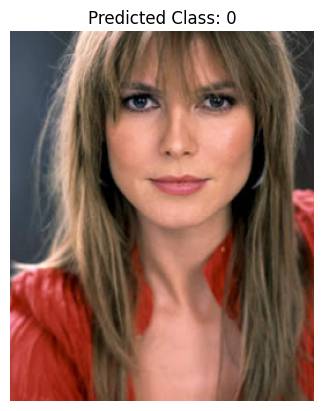

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import files

# 1. Simpan model yang telah dilatih
# Asumsi model sudah dilatih sebelumnya dan disimpan
# model.save('my_trained_model.h5')

# 2. Muat model yang telah disimpan
model = tf.keras.models.load_model('/content/drive/MyDrive/Face Shape/model_facesahpe.h5')

# 3. Preproses gambar manual
def load_and_preprocess_image(image_path):
    img = Image.open(image_path).convert('L')  # Convert to grayscale
    img = img.resize((150, 150))  # Resize to 28x28 pixels
    img = np.array(img)  # Convert to numpy array
    img = img / 255.0  # Normalize to [0, 1]
    img = img.reshape(1, 150, 150, 1)  # Reshape to (1, 28, 28, 1) for model input
    return img

# Path ke gambar manual yang ingin diuji
image_path = files.upload()

# Muat dan preproses gambar
input_image = load_and_preprocess_image(image_path)

# 4. Gunakan model untuk membuat prediksi pada gambar yang telah dipreproses
predictions = model.predict(input_image)
predicted_class = np.argmax(predictions)

# 5. Tampilkan hasil prediksi
print(f'Predicted class: {predicted_class}')

# Visualisasi gambar input
plt.imshow(input_image[0, :, :, 0], cmap='gray')
plt.title(f'Predicted Class: {predicted_class}')
plt.axis('off')
plt.show()


Found 3998 images belonging to 5 classes.


Saving oblong (16).jpg to oblong (16).jpg
1/1 [==============================] - 0s 125ms/step


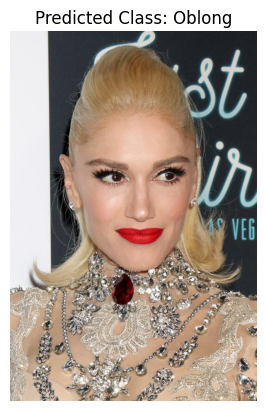

In [ ]:
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():

  path = fn
  img = image.load_img(path, target_size =(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)

In [ ]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/Face Shape/cancer_classification.tflite")
interpreter.allocate_tensors()

In [ ]:
# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Get metadata
with open("metadata.json", 'r') as f:
    metadata = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'metadata.json'